# 0.0) Imports

## 0.0) Libraries

In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import psycopg2 as pg
import scikitplot as skplt

from scipy                   import stats
from boruta                  import BorutaPy
from tabulate                import tabulate
from matplotlib              import pyplot as plt
from sklearn                 import ensemble as en
from sklearn                 import neighbors as nh
from sklearn.model_selection import train_test_split
from sklearn                 import linear_model as lm
from sklearn.datasets        import make_classification
from sklearn                 import preprocessing as pp
from sklearn                 import model_selection as ms
from sklearn.ensemble        import RandomForestClassifier

## 0.1) Data Extraction

In [2]:
# Credentials
credentials = pd.read_csv('conn.csv')

host = credentials['host'][0]
port = credentials['port'][0]
database = credentials['database'][0]
pwd = credentials['pwd'][0]
username = credentials['username'][0]

conn = pg.connect(user=username,
                  password = pwd,
                  host = host,
                  port = port,
                  database = database)

cursor = conn.cursor()


query_tables_users = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle v  ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df1 = pd.read_sql(query_tables_users, conn)
#df1 = df1.drop(df1.columns[5], axis=1)

conn.close()

/home/joaohenritm/anaconda3/envs/pa004/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## 0.2) Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 30
    
    sns.set()
jupyter_settings()



warnings.filterwarnings("ignore")

# 1) Data Description

In [4]:
cols_new = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'ID', 'driving_license', 'vehicle_age', 'vehicle_damage', 'ID', 
                    'previously_insured', 'annual_premium', 'vintage', 'response']

df1.columns = cols_new
df1 = df1.drop(df1.columns[[5, 9]], axis=1)

In [5]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 1.1) Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2) Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3) Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4) Data Descriptive

In [9]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [10]:
 df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# 2) Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                                                       if x == '1-2 Year' else 'below_1_year')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3) Data Filtering

In [13]:
df3 = df2.copy()

# 4) Exploratory Data Analysis

In [14]:
df4 = df3.copy()

## 4.1) Univariate Analysis

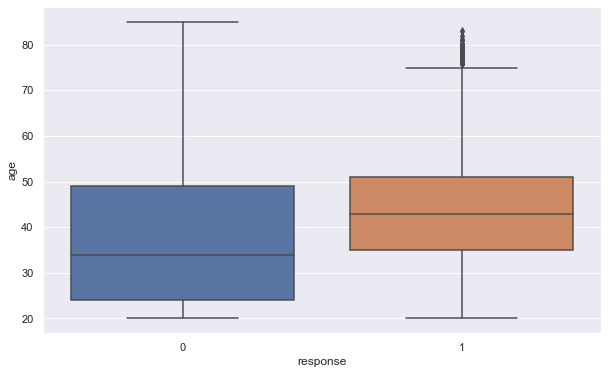

In [15]:
# age
sns.boxplot(x='response', y='age', data=df4);

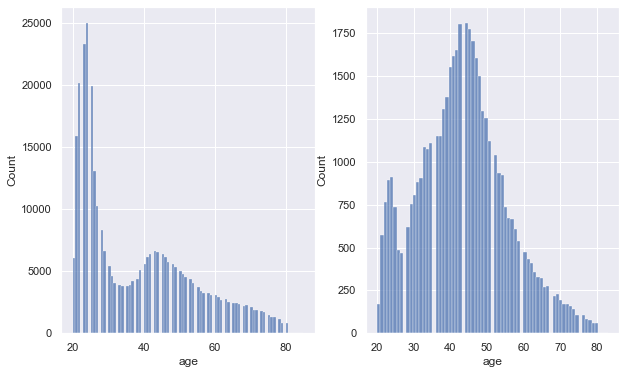

In [16]:
# age
plt.subplot(1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00);

plt.subplot(1, 2, 2)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00);

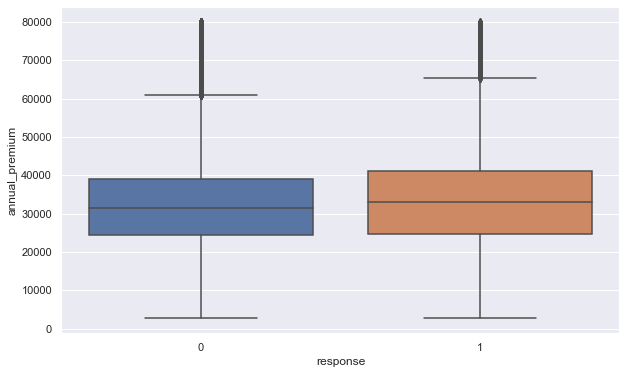

In [17]:
# annual_premium
aux = df4.loc[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

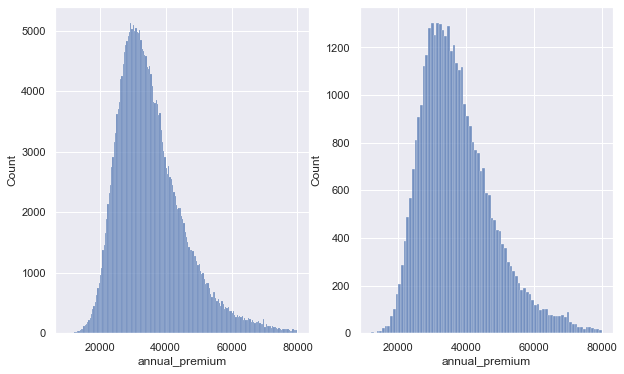

In [18]:
# annual premium
aux = df4.loc[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
plt.subplot(1, 2, 1)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00);

plt.subplot(1, 2, 2)
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00);

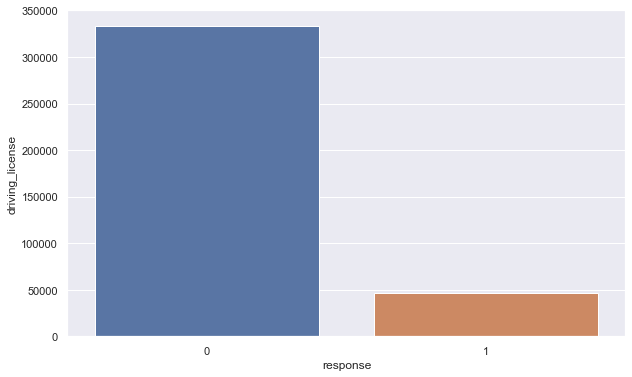

In [19]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

sns.barplot(x='response', y='driving_license', data=aux);

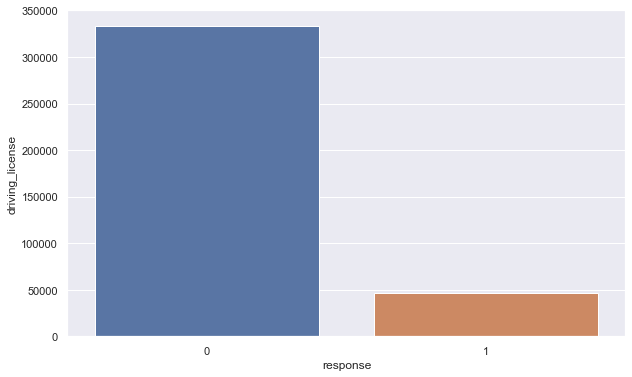

In [20]:
# driving_license
sns.barplot(x='response', y='driving_license', data=aux);

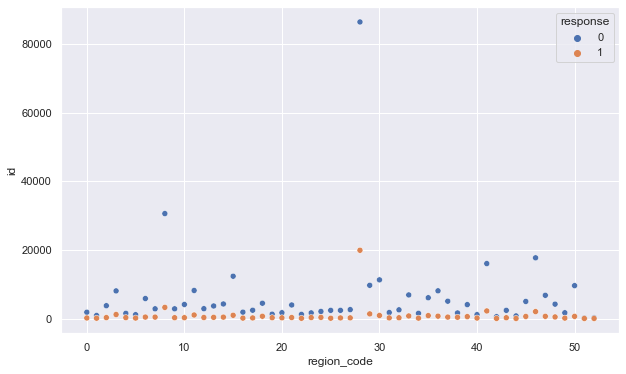

In [21]:
# region code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

In [22]:
# gender

In [23]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [24]:
# vehicle age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


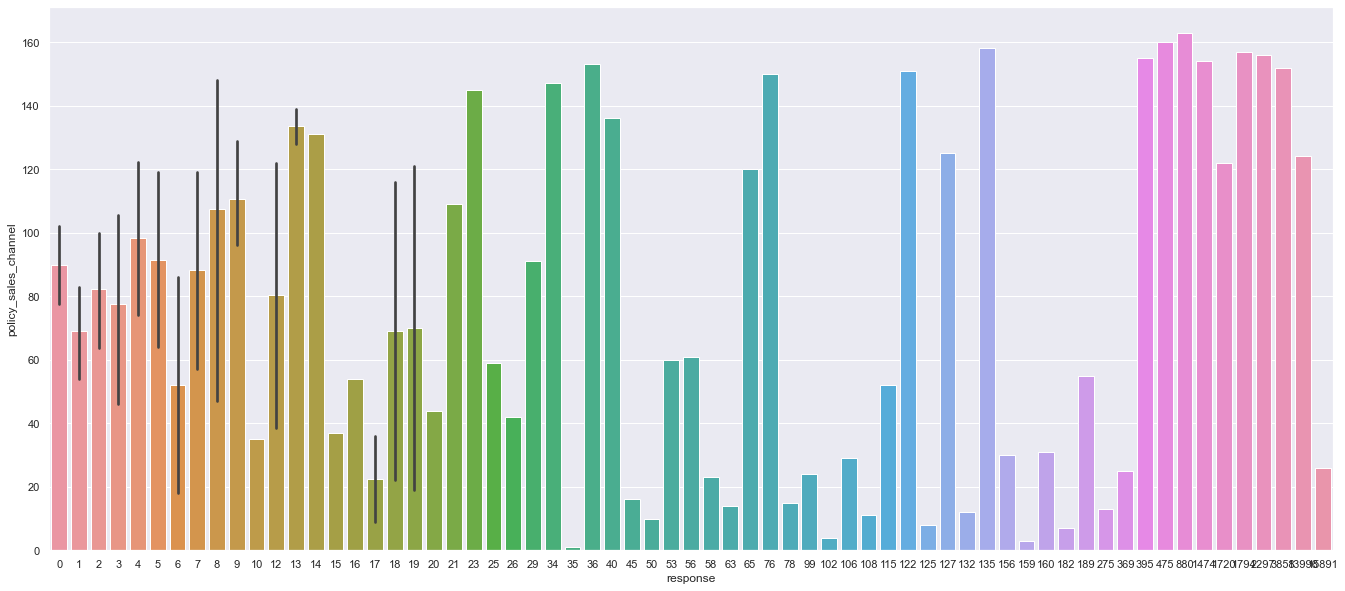

In [25]:
# policy_sales_channel
plt.figure(figsize=(23,10))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux);

<AxesSubplot:xlabel='response', ylabel='vintage'>

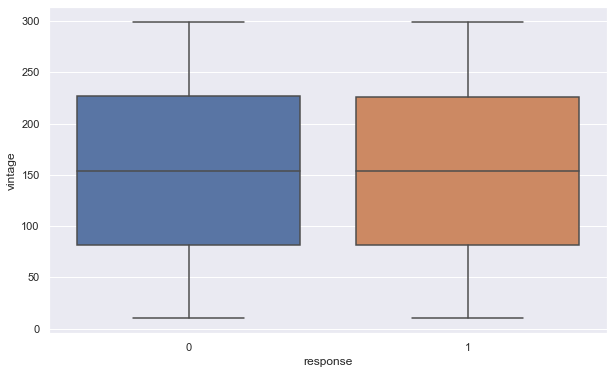

In [26]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4)

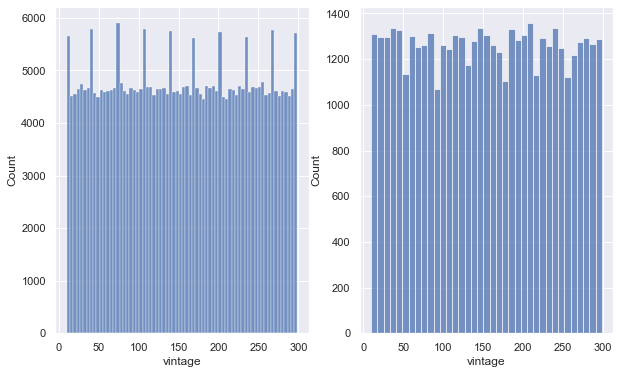

In [27]:
plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux);

plt.subplot(1, 2, 2)
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux);

## 4.2) Numerical Attributes

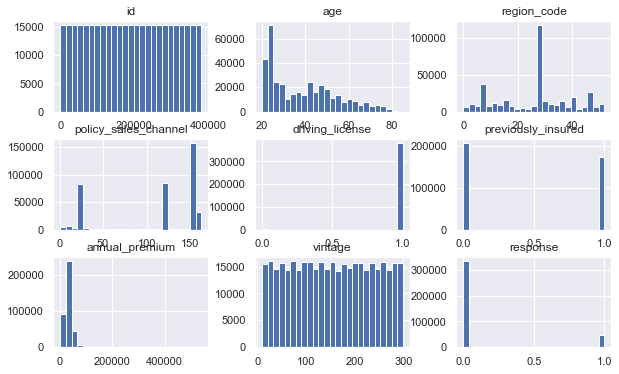

In [28]:
num_attributes.hist(bins=25);

## 4.2) Checking Hypothesis

### H1) In average, Female should buy car insurance. 
**False: In average, Males buy more car insurance.**

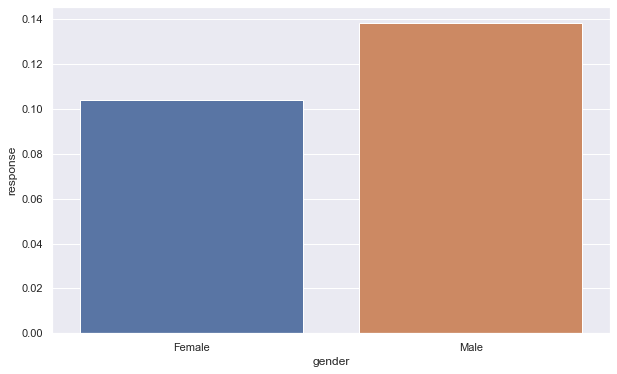

In [29]:
aux1 = df4[['gender', 'response']].groupby('gender').mean().reset_index()
sns.barplot(x='gender', y='response', data=aux1);

### H2) Older people should buy car insurance
**True: People with more than 30 buy more car insurances than people with age between 20-30.**

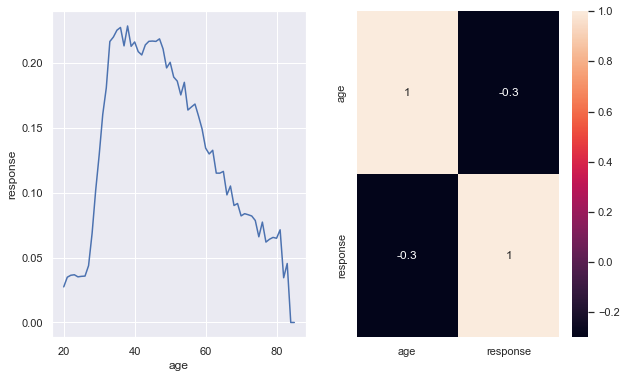

In [30]:
aux1 = df4[['age', 'response']].groupby('age').mean().reset_index()


plt.subplot(1, 2, 1)
sns.lineplot(x='age', y='response', data=aux1);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3: Clients with vehicle damage should buy more car insurance
**True: Clients with vehicle damage buy more car insurance.**

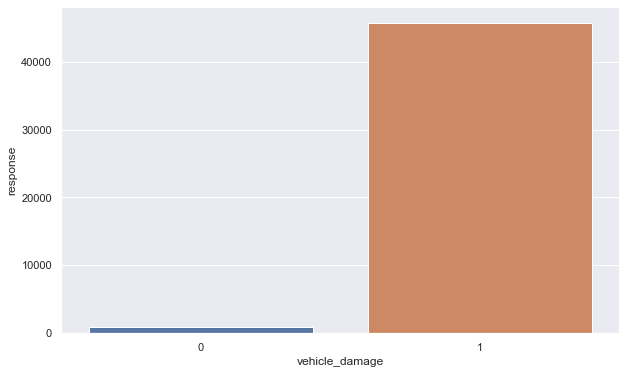

In [31]:
aux1 = df4[['response', 'vehicle_damage']].groupby('vehicle_damage').sum().reset_index()
sns.barplot(x='vehicle_damage', y='response', data=aux1);

### H4: Clients with higher annual premium should buy car insurance.
**Inconclusive: People with an annual premium between 0 to 3000 buy more car insurance than people with more annual premium until the group of people that have more than 33000 annual premium.**

<AxesSubplot:>

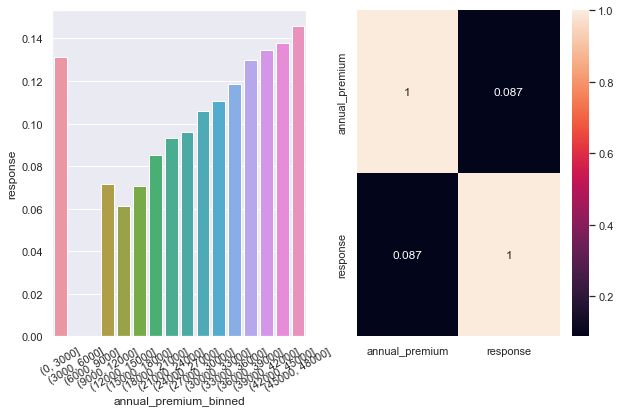

In [32]:
aux1 = df4[['response', 'annual_premium']].groupby('annual_premium').mean().reset_index()
# creating groups
bins = list(np.arange(0, 50000, 3000))
 
aux1['annual_premium_binned'] = pd.cut(aux1['annual_premium'], bins=bins)
aux2 = aux1[['annual_premium_binned', 'response']].groupby('annual_premium_binned').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='annual_premium_binned', y='response', data=aux2);
plt.xticks(rotation=30);

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5) Clients that don't have a driving license should not buy a car insurance.
**True: Clients that don't have a driving license buy much less car insurance than people that have a driving license.**

<AxesSubplot:xlabel='driving_license', ylabel='response'>

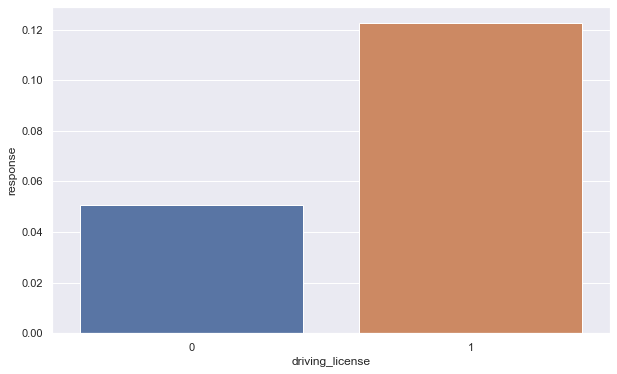

In [33]:
aux1 = df4[['response', 'driving_license']].groupby('driving_license').mean().reset_index()
sns.barplot(x='driving_license', y='response', data=aux1)

### H6: People with more recent cars should be more propense to buy a car insurance.
**False: People with older cars are more propense to buy a car insurance.**

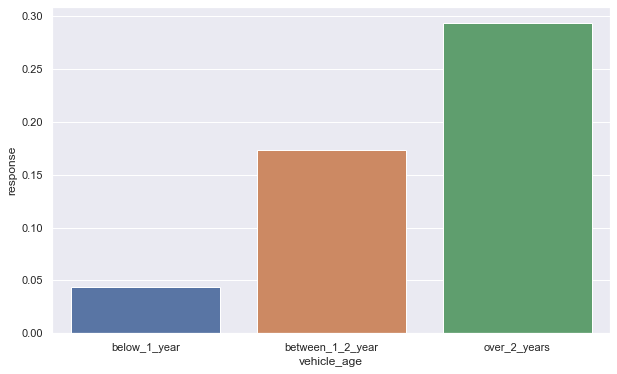

In [34]:
aux1 = df4[['response', 'vehicle_age']].groupby('vehicle_age').mean().sort_values(
                                        by='response', ascending=True).reset_index()

sns.barplot(x='vehicle_age', y='response', data=aux1);

## 4.3) Overview of Hypothesis

In [35]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'True', 'High'],
       ['H3', 'True', 'High'],
       ['H4', 'Inconclusive', 'Medium'],
       ['H5', 'True', 'High'],
       ['H6', 'False', 'High']]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            True          High
H3            True          High
H4            Inconclusive  Medium
H5            True          High
H6            False         High


## 4.4) Multivariated Analysis

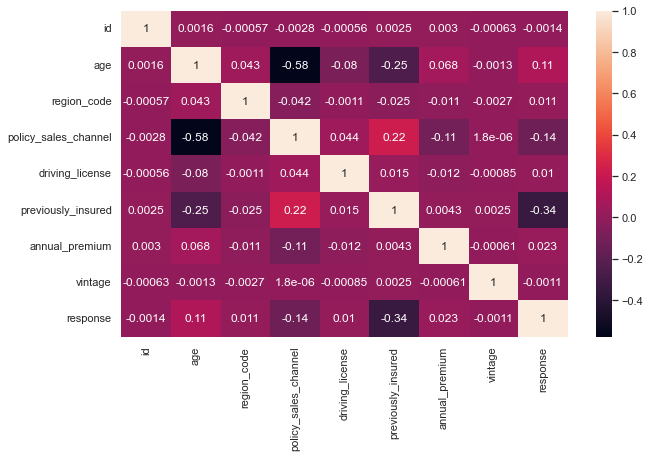

In [36]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5) Data Preparation

In [37]:
df5 = df4.copy()

In [38]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1) Standardization

In [39]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2) Rescaling

In [40]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3) Encoder

In [41]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

## 5.4) Validation Preparation

In [42]:
# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# fillna
x_val = x_val.fillna(0) 

# 6) Feature Selection

In [43]:
df6 = df5.copy()

## Features Importance

In [44]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.272757
0                annual_premium    0.243895
0                           age    0.163548
0                   region_code    0.109070
0                vehicle_damage    0.067334
0          policy_sales_channel    0.058116
0            previously_insured    0.056897
0      vehicle_age_below_1_year    0.014454
0  vehicle_age_between_1_2_year    0.006544
0                        gender    0.004749
0      vehicle_age_over_2_years    0.002158
0               driving_license    0.000478


<function matplotlib.pyplot.show(close=None, block=None)>

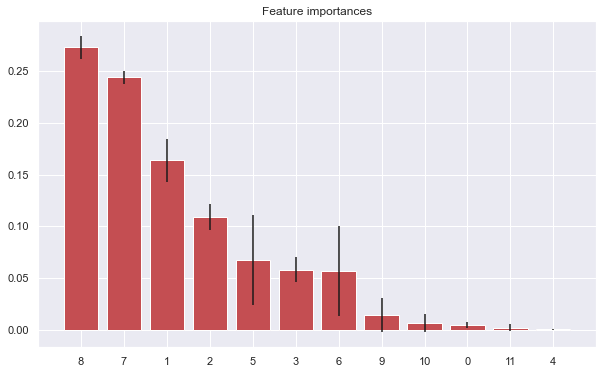

In [45]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show

# 7) Machine Learning

In [46]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']


x_train = df5[cols_selected]
x_val = x_val[cols_selected]

## 7.1) KNN

In [47]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

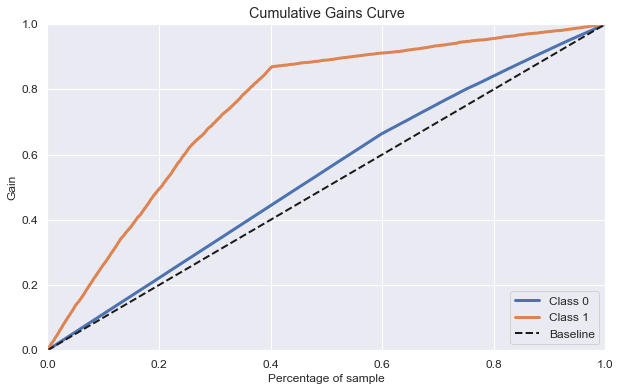

In [48]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

## 7.2) LogisticRegression

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

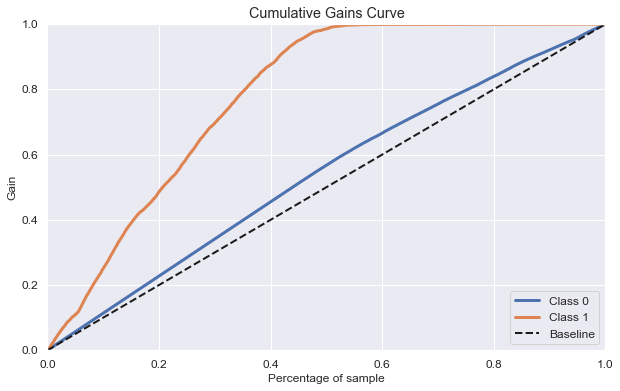

In [49]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

## 7.3) RandomForest

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

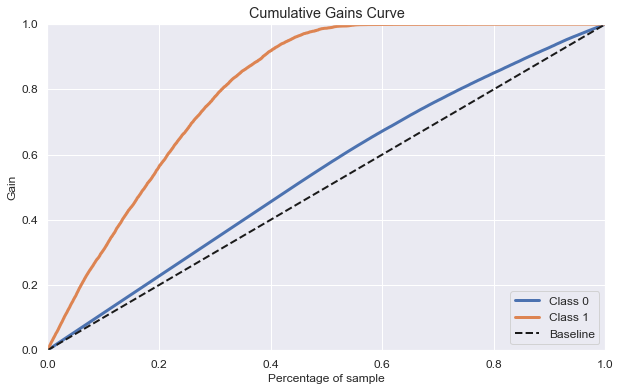

In [50]:
# model definition
rf_model = RandomForestClassifier(n_estimators=700, max_depth=6, random_state=42, n_jobs=-1)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

# accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)